In [401]:
import os
import sys
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import copy as cp
import re
from collections import Counter

In [683]:
mc2_file = "/mnt/MD0_15T/jwkang/BigSize_Profilling/Stool_ColonDisease_200921/Profile/output_closed/otu_table_mc2_w.txt"
mc2_file = "/mnt/MD0_15T/jwkang/BigSize_Profilling/Stool_ColonDisease_200921/Profile/output_closed/otu_table_mc2_w.txt"

In [ ]:
def LoadINPUT(file): ## input file which is setup at R
    D1 = pd.read_csv(file, index_col=0)
    return(D1.iloc[:-1,:], D1.loc['Group',:]) #return : (x, y) y~last column named 'Group' & [0.1/0.9]

In [684]:
def OTU2DF_log2(mc2, Smp_filter_otu = 1000, RelativeAbundance = True): ## input from qiime1 profiling
    DT1 = pd.read_csv(mc2, sep="\t", skiprows=1, index_col=0)
    
    ## OTU 1000 filter
    
    ## D_0__ 제거
    ## Mitochondria/Chloroplast 제거
    idx_filt = [(re.search("D_0__", x) == None) and \
                (re.search("Mitochondria", x) == None) and \
                (re.search("Chloroplast", x) == None) for x in DT1.taxonomy]
    DT1 = DT1[idx_filt]
    ## g__unculture/unidentified ~~ -> unidentified 통일
    DT1.taxonomy = [re.sub("; g__.*", "; g__unidentified; s__unidentified", tx) if re.search('g_un', tx) != None else tx for tx in DT1.taxonomy]
    
    DicX = {}
    for tx in range(len(DT1['taxonomy'])):
        txSplt = DT1['taxonomy'][tx].split("; s__")
        if len(txSplt) == 2:
            taxID = txSplt[0]
            try:
                DicX[taxID] = DicX[taxID] + DT1.iloc[tx,:-1]
            except :
                DicX[taxID] = DT1.iloc[tx,:-1]

    Xdf = pd.DataFrame.from_dict(DicX)
    DataIN = (Xdf[Xdf.sum(axis=1) >= Smp_filter_otu]+1).applymap(np.log2).T
    DataOUT = Xdf[Xdf.sum(axis=1) < Smp_filter_otu].T
    
    if RelativeAbundance is True:
        DataIN = DataIN/DataIN.sum()
    
    return(DataIN, DataOUT)

In [685]:
Otu1, Out = otu2log2TAXA(mc2)

In [682]:
def FeatureStats(data, label, leven_Cutoff = 0.05):    
    TaxaIDs = []
    Levens = []
    Equality = []
    TPs = []
    Avg = []; SD = []
    Med = []; Max = []; Min = []

    for i in range(data.shape[0]):
        D_i = data.iloc[i,:]

        #shaP = stats.shapiro(D_i)[1]
        levP = stats.levene(D_i[label == 0.1], D_i[label == 0.9])[1]
        #print(shaP, levP)
        equl = (levP > leven_Cutoff)
        if(equl): #두 그룹의 분산이 같음 -> equal_var=True
            Pval = stats.ttest_ind(D_i[label == 0.1], D_i[label == 0.9], equal_var=True)[1]
        else:
            Pval = stats.ttest_ind(D_i[label == 0.1], D_i[label == 0.9], equal_var=False)[1]

        TaxaIDs.append(D_i.name)
        Levens.append(levP)
        Equality.append(equl)
        TPs.append(Pval)
        Avg.append(D_i.mean())
        SD.append(np.std(D_i))
        Med.append(np.median(D_i))
        Max.append(np.max(D_i))
        Min.append(np.min(D_i))

    TestResDic = {'Taxa_ID':TaxaIDs, 'Leven_Pval':Levens, \
                  'Var_Equal':Equality, 'Ttest_Pval':TPs, \
                  'Average':Avg, 'SD':SD, 'Median':Med, 'Max':Max, 'Min':Min}
    TestResDF = pd.DataFrame(TestResDic).sort_values('Average', ascending=False).reset_index().iloc[:,1:]
    
    return(TestResDF)

In [337]:
D_stat = FeatureStats(D_main[0], D_main[1])

In [359]:
def SelcFeatures(Fstat_data, Cutoff = 0.1): ## Cutoff unit: (%)
    Cutoffp = Cutoff*0.01
    #return(Fstat_data.iloc[:round(Fstat_data.shape[0]*Quantile),].Taxa_ID)
    return(Fstat_data[Fstat_data.Average >= Cutoffp].Taxa_ID)

In [469]:
D_acc_1 = D_main[0].loc[D_main[0].index.sort_values(),:]

In [528]:
#1. K__ True 합
LevSep = ['p', 'c', 'o', 'f', 'g']
#LevSep = ['p', 'c', 'o']

ACC_Dict = {}

accK = 1e-7
for lv in LevSep:
    
    accK = accK*10
    
    print('ACC start for {}!'.format(lv))
    
    Idx1 = [x.split('; {}__'.format(lv))[0] for x in D_acc_1.index.tolist()]
    Kys = list(Counter(Idx1).keys())
    
    for Ky in Kys:
        #print(Ky)
        tmpA = D_acc_1[np.array(Idx1) == Ky]
        if Ky == Kys[0]:
            ACCt = pd.DataFrame(0, index=tmpA.index, columns=tmpA.columns) + (tmpA.sum()*accK)
        else:
            ACCt = ACCt.append(pd.DataFrame(0, index=tmpA.index, columns=tmpA.columns) + (tmpA.sum()*accK))
    
    ACC_Dict[lv] = ACCt

ACC start for p!
ACC start for c!
ACC start for o!
ACC start for f!
ACC start for g!


In [531]:
ACC_DF = ACC_Dict['p'] + ACC_Dict['c'] + ACC_Dict['o'] + ACC_Dict['f'] + ACC_Dict['g'] + D_acc_1

In [535]:
D_acc_1.sum()

ST0449S    1.382438
ST0450S    1.364469
ST0496S    1.390618
ST0510S    1.483859
ST0515S    1.343264
             ...   
ST4187S    1.436071
ST4188S    1.480101
ST4189S    1.451732
ST4194S    1.405353
ST4196S    1.387183
Length: 318, dtype: float64

In [534]:
ACC_DF.sum()

ST0449S    2.011942
ST0450S    1.964926
ST0496S    2.025939
ST0510S    2.299988
ST0515S    1.875139
             ...   
ST4187S    2.209670
ST4188S    2.358754
ST4189S    2.254220
ST4194S    2.108918
ST4196S    2.021165
Length: 318, dtype: float64

In [514]:
ACC_Dict['c'].shape

(1462, 318)

In [473]:
#D_acc_1[Idx1 == Ky]

In [484]:
for Ky in Kys:
    print(Ky)
    tmpA = D_acc_1[np.array(Idx1) == Ky]
    if Ky == Kys[0]:
        ACCt = pd.DataFrame(0, index=tmpA.index, columns=tmpA.columns) + tmpA.sum()
    else:
        ACCt = ACC.append(pd.DataFrame(0, index=tmpA.index, columns=tmpA.columns) + tmpA.sum())
    


k__Archaea
k__Bacteria


In [479]:
tmpA = D_acc_1[np.array(Idx1) == Kys[1]]

In [485]:
ACC

,ST0449S,ST0450S,ST0496S,ST0510S,ST0515S,ST0518S,ST0520S,ST0523S,ST0525S,ST0798S,...,ST4091S,ST4100S,ST4106S,ST4111S,ST4141S,ST4187S,ST4188S,ST4189S,ST4194S,ST4196S
k__Archaea; p__Euryarchaeota; c__Halobacteria; o__Halobacteriales; f__Haloferacaceae; g__Halolamina;,0.000000,0.000000,0.000000,0.001677,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,...,0.009317,0.000000,0.00000,0.005559,0.011046,0.035535,0.000000,0.000000,0.006103,0.014394
k__Archaea; p__Euryarchaeota; c__Methanobacteria; o__Methanobacteriales; f__Methanobacteriaceae; g__Methanobacterium;,0.000000,0.000000,0.000000,0.001677,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,...,0.009317,0.000000,0.00000,0.005559,0.011046,0.035535,0.000000,0.000000,0.006103,0.014394
k__Archaea; p__Euryarchaeota; c__Methanobacteria; o__Methanobacteriales; f__Methanobacteriaceae; g__Methanobrevibacter;,0.000000,0.000000,0.000000,0.001677,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,...,0.009317,0.000000,0.00000,0.005559,0.011046,0.035535,0.000000,0.000000,0.006103,0.014394
k__Archaea; p__Euryarchaeota; c__Methanobacteria; o__Methanobacteriales; f__Methanobacteriaceae; g__Methanosphaera;,0.000000,0.000000,0.000000,0.001677,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,...,0.009317,0.000000,0.00000,0.005559,0.011046,0.035535,0.000000,0.000000,0.006103,0.014394
k__Archaea; p__Euryarchaeota; c__Thermoplasmata; o__Methanomassiliicoccales; f__Methanomethylophilaceae; g__Candidatus Methanomethylophilus;,0.000000,0.000000,0.000000,0.001677,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,...,0.009317,0.000000,0.00000,0.005559,0.011046,0.035535,0.000000,0.000000,0.006103,0.014394
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
k__Bacteria; p__Verrucomicrobia; c__Verrucomicrobiae; o__Verrucomicrobiales; f__Verrucomicrobiaceae; g__Roseimicrobium;,1.382438,1.364469,1.390618,1.482182,1.343264,1.427342,1.501361,1.393659,1.505799,1.42052,...,1.502901,1.486015,1.53869,1.529219,1.582937,1.400536,1.480101,1.451732,1.399250,1.372789
k__Bacteria; p__Verrucomicrobia; c__Verrucomicrobiae; o__Verrucomicrobiales; f__Verrucomicrobiaceae; g__unidentified,1.382438,1.364469,1.390618,1.482182,1.343264,1.427342,1.501361,1.393659,1.505799,1.42052,...,1.502901,1.486015,1.53869,1.529219,1.582937,1.400536,1.480101,1.451732,1.399250,1.372789
k__Bacteria; p__WPS-2; c__metagenome; o__metagenome; f__metagenome; g__metagenome;,1.382438,1.364469,1.390618,1.482182,1.343264,1.427342,1.501361,1.393659,1.505799,1.42052,...,1.502901,1.486015,1.53869,1.529219,1.582937,1.400536,1.480101,1.451732,1.399250,1.372789
k__Bacteria; p__WPS-2; c__uncultured bacterium; o__uncultured bacterium; f__uncultured bacterium; g__unidentified,1.382438,1.364469,1.390618,1.482182,1.343264,1.427342,1.501361,1.393659,1.505799,1.42052,...,1.502901,1.486015,1.53869,1.529219,1.582937,1.400536,1.480101,1.451732,1.399250,1.372789


In [424]:
IX = list(Counter(Idx1).keys())[0]

In [451]:
tmpA = D_acc_1[np.array(Idx1) == IX]

In [461]:
pd.DataFrame(0, index=tmpA.index, columns=tmpA.columns) + tmpA.sum()

,ST0449S,ST0450S,ST0496S,ST0510S,ST0515S,ST0518S,ST0520S,ST0523S,ST0525S,ST0798S,...,ST4091S,ST4100S,ST4106S,ST4111S,ST4141S,ST4187S,ST4188S,ST4189S,ST4194S,ST4196S
k__Archaea; p__Euryarchaeota; c__Halobacteria; o__Halobacteriales; f__Haloferacaceae; g__Halolamina;,0.0,0.0,0.0,0.001677,0.0,0.0,0.0,0.0,0.0,0.0,...,0.009317,0.0,0.0,0.005559,0.011046,0.035535,0.0,0.0,0.006103,0.014394
k__Archaea; p__Euryarchaeota; c__Methanobacteria; o__Methanobacteriales; f__Methanobacteriaceae; g__Methanobacterium;,0.0,0.0,0.0,0.001677,0.0,0.0,0.0,0.0,0.0,0.0,...,0.009317,0.0,0.0,0.005559,0.011046,0.035535,0.0,0.0,0.006103,0.014394
k__Archaea; p__Euryarchaeota; c__Methanobacteria; o__Methanobacteriales; f__Methanobacteriaceae; g__Methanobrevibacter;,0.0,0.0,0.0,0.001677,0.0,0.0,0.0,0.0,0.0,0.0,...,0.009317,0.0,0.0,0.005559,0.011046,0.035535,0.0,0.0,0.006103,0.014394
k__Archaea; p__Euryarchaeota; c__Methanobacteria; o__Methanobacteriales; f__Methanobacteriaceae; g__Methanosphaera;,0.0,0.0,0.0,0.001677,0.0,0.0,0.0,0.0,0.0,0.0,...,0.009317,0.0,0.0,0.005559,0.011046,0.035535,0.0,0.0,0.006103,0.014394
k__Archaea; p__Euryarchaeota; c__Thermoplasmata; o__Methanomassiliicoccales; f__Methanomethylophilaceae; g__Candidatus Methanomethylophilus;,0.0,0.0,0.0,0.001677,0.0,0.0,0.0,0.0,0.0,0.0,...,0.009317,0.0,0.0,0.005559,0.011046,0.035535,0.0,0.0,0.006103,0.014394
k__Archaea; p__Euryarchaeota; c__Thermoplasmata; o__Methanomassiliicoccales; f__Methanomethylophilaceae; g__unidentified,0.0,0.0,0.0,0.001677,0.0,0.0,0.0,0.0,0.0,0.0,...,0.009317,0.0,0.0,0.005559,0.011046,0.035535,0.0,0.0,0.006103,0.014394


In [458]:
tmpA + tmpA.sum()

In [436]:
pd.DataFrame(D_acc_1[np.array(Idx1) == IX].sum(axis = 0)).T

,ST0449S,ST0450S,ST0496S,ST0510S,ST0515S,ST0518S,ST0520S,ST0523S,ST0525S,ST0798S,...,ST4091S,ST4100S,ST4106S,ST4111S,ST4141S,ST4187S,ST4188S,ST4189S,ST4194S,ST4196S
0,0.0,0.0,0.0,0.001677,0.0,0.0,0.0,0.0,0.0,0.0,...,0.009317,0.0,0.0,0.005559,0.011046,0.035535,0.0,0.0,0.006103,0.014394


In [411]:
dict('c', 'c', 'c', 'a', 'a', 'b')

TypeError: dict expected at most 1 arguments, got 6

In [397]:
Counter(Idx1)

Counter({'k__Archaea': 6, 'k__Bacteria': 1456})

In [360]:
Feas = SelcFeatures(D_stat)

In [362]:
D_main_selc = D_main[0].loc[Feas,:]

In [ ]:
def TrainTestSplit(DF, ratio=0.3, Label=0.1, Compose=True):
    if Compose: ### 상대값으로 보정 샘플균 총량합 100
        for i in range(DF.shape[0]):
            DF.iloc[i,:] = (DF.iloc[i,:]/sum(DF.iloc[i,:]))*100
    DF['Group'] = Label
    import random
    xi = np.arange(DF.shape[0])
    np.random.seed(3492)
    np.random.shuffle(xi)
    xi = xi.tolist()

    Testx = DF.iloc[xi[:round(DF.shape[0]*ratio)],:]
    Trainx = DF.iloc[xi[round(DF.shape[0]*ratio):],:]
    return({'TEST':Testx, 'TRAIN':Trainx})

In [287]:
np.sqrt(len(vec_sec))

16.703293088490067

In [304]:
B = [0,0,0]

In [301]:
B.append(B)

In [307]:
[0 for x in range(n - len(vec_sec))] + 

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [306]:
n - len(vec_sec)

10

In [313]:
int(np.sqrt(len(vec_sec)))+1

16

In [316]:
# Vec2IMG
def Vec2IMG(Vector):
    vec_sec = Vector
    INn = int(np.sqrt(len(vec_sec)))+1
    sampleID = vec_sec.name
    vec_sec = vec_sec.to_list()
    vec_sec.reverse()
    Dlist = [0 for x in range(n - len(vec_sec))] + vec_sec
    n = INn**2
    pos = np.array([0,0])
    POSlist = list()
    POSlist.append(pos)
    xx = [int(np.sqrt(n)-1)]
    for x in range(int(np.sqrt(n)-1), 0, -1):
        xx.append(x)
        xx.append(x)
    for i in range( ((int(np.sqrt(n)-1))*2) + 1 ):
        #print(pos)
        #print(i, POSlist)
        if i % 4 == 0:
            for j in range(xx[i]):
                pos = pos + [1,0]
                POSlist.append(pos)
        if i % 4 == 1:
            for j in range(xx[i]):
                pos = pos + [0,1]
                POSlist.append(pos)
        if i % 4 == 2:
            for j in range(xx[i]):
                pos = pos + [-1,0]
                POSlist.append(pos)
        if i % 4 == 3:
            for j in range(xx[i]):
                pos = pos + [0,-1]
                POSlist.append(pos)
    ARRY = np.zeros([INn,INn])
    for i in range(len(Dlist)):
        ARRY[POSlist[i].tolist()[0], POSlist[i].tolist()[1]] = Dlist[i]

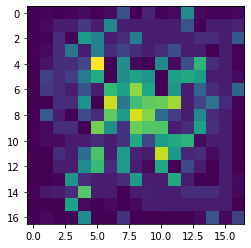

In [309]:
plt.imshow(ARRY)

In [278]:
len(Dlist)

279

In [273]:
ARRY

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0.